<a href="https://colab.research.google.com/github/eecastillo/parkinson_analisis/blob/master/notebooks/audio_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install praat-parselmouth
!pip install my-voice-analysis


     |████████████████████████████████| 10.7 MB 31.1 MB/s 


In [ ]:
#!/usr/bin/env python3
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics

from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

In [ ]:
# This is the function to measure voice pitch
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    point_process = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    voice_report = parselmouth.praat.call([sound, pitch, point_process], "Voice report", 0, 0, 75, 600, 1.3, 1.6, 0.03, 0.45)
    print(voice_report)

    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [ ]:
def getData(voiceID):
    sound = parselmouth.Sound(voiceID)
    pitch = sound.to_pitch_ac(very_accurate=False)
    point_process = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
    voice_report = parselmouth.praat.call([sound, pitch, point_process], "Voice report", 0, 0, 75, 600, 1.3, 1.6, 0.03, 0.45)
    return voice_report

In [ ]:
"""
Missing features, further investigation needed
features 12-14: AC,NTH,HTN,
features 15-19: Median pitch,Minimum pitch,Maximum pitch,
features 20-23: Number of pulses,Number of periods,Mean period,Standard deviation of period, 
features 24-26: Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks
"""

'\nMissing features, further investigation needed\nfeatures 12-14: AC,NTH,HTN,\nfeatures 15-19: Median pitch,Minimum pitch,Maximum pitch,\nfeatures 20-23: Number of pulses,Number of periods,Mean period,Standard deviation of period, \nfeatures 24-26: Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks\n'

In [ ]:
sound = parselmouth.Sound("/content/fer_audio.wav")


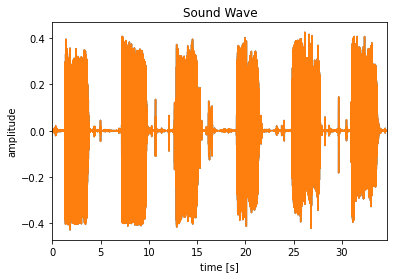

In [ ]:
plt.figure()
plt.plot(sound.xs(), sound.values.T)
plt.xlim([sound.xmin, sound.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.title("Sound Wave")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

In [ ]:
spectrogram = sound.to_spectrogram()


In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


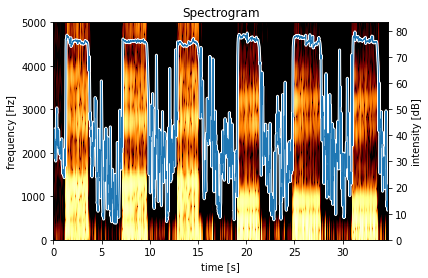

In [ ]:
intensity = sound.to_intensity()
spectrogram = sound.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([sound.xmin, sound.xmax])
plt.title("Spectrogram")
plt.show()

In [ ]:
(meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")

   From 0 to 0 seconds (duration: 34.709333 seconds)
Pitch:
   Median pitch: 146.356 Hz
   Mean pitch: 145.012 Hz
   Standard deviation: 6.892 Hz
   Minimum pitch: 77.629 Hz
   Maximum pitch: 161.866 Hz
Pulses:
   Number of pulses: 2329
   Number of periods: 2304
   Mean period: 6.890465E-3 seconds
   Standard deviation of period: 0.367741E-3 seconds
Voicing:
   Fraction of locally unvoiced frames: 52.495%   (1820 / 3467)
   Number of voice breaks: 21
   Degree of voice breaks: 47.845%   (16.606657 seconds / 34.709333 seconds)
Jitter:
   Jitter (local): 0.474%
   Jitter (local, absolute): 32.678E-6 seconds
   Jitter (rap): 0.180%
   Jitter (ppq5): 0.186%
   Jitter (ddp): 0.541%
Shimmer:
   Shimmer (local): 3.773%
   Shimmer (local, dB): 0.388 dB
   Shimmer (apq3): 1.923%
   Shimmer (apq5): 2.340%
   Shimmer (apq11): 2.768%
   Shimmer (dda): 5.769%
Harmonicity of the voiced parts only:
   Mean autocorrelation: 0.971510
   Mean noise-to-harmonics ratio: 0.036866
   Mean harmonics-to-nois

In [ ]:
voice_report = getData(sound)
print(voice_report)

   From 0 to 0 seconds (duration: 34.709333 seconds)
Pitch:
   Median pitch: 146.356 Hz
   Mean pitch: 145.012 Hz
   Standard deviation: 6.892 Hz
   Minimum pitch: 77.629 Hz
   Maximum pitch: 161.866 Hz
Pulses:
   Number of pulses: 2329
   Number of periods: 2304
   Mean period: 6.890465E-3 seconds
   Standard deviation of period: 0.367741E-3 seconds
Voicing:
   Fraction of locally unvoiced frames: 52.495%   (1820 / 3467)
   Number of voice breaks: 21
   Degree of voice breaks: 47.845%   (16.606657 seconds / 34.709333 seconds)
Jitter:
   Jitter (local): 0.474%
   Jitter (local, absolute): 32.678E-6 seconds
   Jitter (rap): 0.180%
   Jitter (ppq5): 0.186%
   Jitter (ddp): 0.541%
Shimmer:
   Shimmer (local): 3.773%
   Shimmer (local, dB): 0.388 dB
   Shimmer (apq3): 1.923%
   Shimmer (apq5): 2.340%
   Shimmer (apq11): 2.768%
   Shimmer (dda): 5.769%
Harmonicity of the voiced parts only:
   Mean autocorrelation: 0.971510
   Mean noise-to-harmonics ratio: 0.036866
   Mean harmonics-to-nois

In [ ]:
parameters = ["Jitter (local): ","Jitter (local, absolute): ","Jitter (rap): ","Jitter (ppq5): ","Jitter (ddp): ",
              "Shimmer (local): ","Shimmer (local, dB): ","Shimmer (apq3): ","Shimmer (apq5): ","Shimmer (apq11): ","Shimmer (dda): ",
              "Mean autocorrelation: ","Mean noise-to-harmonics ratio: ","Mean harmonics-to-noise ratio: ",
              "Median pitch: ","Mean pitch: ","Standard deviation: ","Minimum pitch: ","Maximum pitch: ",
              "Number of pulses: ","Number of periods: ","Mean period: ","Standard deviation of period: ",
              "Fraction of locally unvoiced frames: ","Number of voice breaks: ","Degree of voice breaks: "]

In [ ]:
parameters_j_units = ["%\n","seconds\n","%\n","%\n","%\n",
                      "%\n","dB\n","%\n","%\n","%\n","%\n",
                      "\n","\n","dB\n",
                      "Hz\n","Hz\n","Hz\n","Hz\n","Hz\n",
                      "\n","\n","seconds\n","seconds\n",
                      "%","\n","%"]

In [ ]:
len(parameters_j_units)

26

In [ ]:
def getDataFromReport(voice_report_data):
  voice_df = pd.DataFrame(columns = parameters)
  for p_index in range(len(parameters)):
    i = voice_report_data.index(parameters[p_index]) + len(parameters[p_index])
    j = voice_report_data.index(parameters_j_units[p_index], i)
    voice_data = float(voice_report_data[i:j])
    if("%" in parameters_j_units[p_index]):
      voice_data = voice_data/100
    voice_df.loc[1, parameters[p_index]] = voice_data
    #print(parameters[p_index]+"  "+str(voice_data))
  return voice_df

In [ ]:
voice_report = getData(sound)
i = voice_report.index("Fraction of locally unvoiced frames: ") + len("Fraction of locally unvoiced frames: ")
j = voice_report.index("%", i)

In [ ]:
float(voice_report[i:j])

52.495

In [ ]:
getDataFromReport(voice_report)


,Jitter (local):,"Jitter (local, absolute):",Jitter (rap):,Jitter (ppq5):,Jitter (ddp):,Shimmer (local):,"Shimmer (local, dB):",Shimmer (apq3):,Shimmer (apq5):,Shimmer (apq11):,Shimmer (dda):,Mean autocorrelation:,Mean noise-to-harmonics ratio:,Mean harmonics-to-noise ratio:,Median pitch:,Mean pitch:,Standard deviation:,Minimum pitch:,Maximum pitch:,Number of pulses:,Number of periods:,Mean period:,Standard deviation of period:,Fraction of locally unvoiced frames:,Number of voice breaks:,Degree of voice breaks:
1,0.00474,3.2678e-05,0.0018,0.00186,0.00541,0.03773,0.388,0.01923,0.0234,0.02768,0.05769,0.97151,0.036866,20.101,146.356,145.012,6.892,77.629,161.866,2329,2304,0.00689047,0.000367741,0.52495,21,0.47845


In [ ]:
# create lists to put the results
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []

In [ ]:
mean_F0_list.append(meanF0) # make a mean F0 list
sd_F0_list.append(stdevF0) # make a sd F0 list
hnr_list.append(hnr)
localJitter_list.append(localJitter)
localabsoluteJitter_list.append(localabsoluteJitter)
rapJitter_list.append(rapJitter)
ppq5Jitter_list.append(ppq5Jitter)
ddpJitter_list.append(ddpJitter)
localShimmer_list.append(localShimmer)
localdbShimmer_list.append(localdbShimmer)
apq3Shimmer_list.append(apq3Shimmer)
aqpq5Shimmer_list.append(aqpq5Shimmer)
apq11Shimmer_list.append(apq11Shimmer)
ddaShimmer_list.append(ddaShimmer)

In [ ]:
#df = pd.DataFrame(np.column_stack([mean_F0_list, sd_F0_list, hnr_list, localJitter_list, localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list]),
#                              columns=['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
#                                      'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
#                                        'apq11Shimmer', 'ddaShimmer'])  #add these lists to pandas in the right order
df = pd.DataFrame(np.column_stack([localJitter_list, localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list, mean_F0_list, sd_F0_list]),
                  columns=['jitter_local','jitter_local_absolute','jitter_rap','jitter_ppq5','jitter_ddp','shimmer_local','shimer_local_db','shimmer_apq3','shimmer_apq5','shimmer_apq11','shimer_dda','median_pitch','standard_deviation'])


In [ ]:
df

,jitter_local,jitter_local_absolute,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimer_local_db,shimmer_apq3,shimmer_apq5,shimmer_apq11,shimer_dda,median_pitch,standard_deviation
0,0.007076,0.00007,0.003893,0.003839,0.011679,0.060883,0.571816,0.035282,0.03412,0.044636,0.105847,100.701584,16.399193


In [ ]:
df_voice_report = getDataFromReport(voice_report)


In [ ]:
df_voice_report

,Jitter (local):,"Jitter (local, absolute):",Jitter (rap):,Jitter (ppq5):,Jitter (ddp):,Shimmer (local):,"Shimmer (local, dB):",Shimmer (apq3):,Shimmer (apq5):,Shimmer (apq11):,Shimmer (dda):,Mean autocorrelation:,Mean noise-to-harmonics ratio:,Mean harmonics-to-noise ratio:,Median pitch:,Mean pitch:,Standard deviation:,Minimum pitch:,Maximum pitch:,Number of pulses:,Number of periods:,Mean period:,Standard deviation of period:,Fraction of locally unvoiced frames:,Number of voice breaks:,Degree of voice breaks:
1,0.00474,3.2678e-05,0.0018,0.00186,0.00541,0.03773,0.388,0.01923,0.0234,0.02768,0.05769,0.97151,0.036866,20.101,146.356,145.012,6.892,77.629,161.866,2329,2304,0.00689047,0.000367741,0.52495,21,0.47845


In [ ]:
from google.colab import files


In [ ]:
#save dataframe csv
df_voice_report.to_csv('audio_new_fer_test.csv',index=False)

In [ ]:
files.download('audio_new_fer_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>